In [2]:
#import libraries
import pandas as pd
import requests
import json
import random
from dateutil import parser
import matplotlib.pyplot as plt

In [3]:
##importing clinicaltrials.gov data using an API
#total number of fields 22351 with expression "geriatric"
#since 22351 is too big of a number we will randomly sample 5 1000 records to do an exploratory analysis

#parameters 
max_fields = 22351
numDFs = 5

randNum =  [None] * 5
for i in range(numDFs): 
  randNum[i] = random.randint(1,max_fields-1000)


urls = [None]*len(randNum)
for i in range(numDFs):
  urls[i] = "https://clinicaltrials.gov/api/query/study_fields?expr=geriatric&fields=NCTId%2CBriefTitle%2CCondition%2CStartDate%2CMinimumAge%2CMaximumAge%2CGender%2C+OverallStatus%2CPrimaryOutcomeTimeFrame%2C+OutcomeMeasureTimeFrame%2C+StudyPopulation&min_rnk="+str(randNum[i])+"&max_rnk="+str(randNum[i]+999)+"&fmt=json"
 

In [9]:
data1 = requests.get(urls[0]).json()
data2 = requests.get(urls[1]).json()
data3 = requests.get(urls[2]).json()
data4 = requests.get(urls[3]).json()
data5 = requests.get(urls[4]).json()

In [10]:
df = pd.DataFrame(columns=["title","date","condition","minage","maxage"])

def addDataPoints(jsonData, df):
    for i in range(1000):

        title = jsonData["StudyFieldsResponse"]["StudyFields"][i]["BriefTitle"][0]
        
        if(len(jsonData["StudyFieldsResponse"]["StudyFields"][i]["StartDate"])== 0):
          date = None
        else:
          date = parser.parse(jsonData["StudyFieldsResponse"]["StudyFields"][i]["StartDate"][0])

        condition = jsonData["StudyFieldsResponse"]["StudyFields"][i]["Condition"][0]


        if(len(jsonData["StudyFieldsResponse"]["StudyFields"][i]["MinimumAge"]) == 0):
          minage = None
        else:
          minage = jsonData["StudyFieldsResponse"]["StudyFields"][i]["MinimumAge"][0]

        if(len(jsonData["StudyFieldsResponse"]["StudyFields"][i]["MaximumAge"])== 0):
          maxage=None
        else:
          maxage = jsonData["StudyFieldsResponse"]["StudyFields"][i]["MaximumAge"][0]
          

        df = pd.concat([df, pd.DataFrame({"title":[title], "date":[date], "condition":[condition], "minage":[minage], "maxage":[maxage]})], ignore_index=True)
    return df

In [11]:
df1 = addDataPoints(data1, df)
df2 = addDataPoints(data2, df)
df3 = addDataPoints(data3, df)
df4 = addDataPoints(data4, df)
df5 = addDataPoints(data5, df)
df_final = pd.concat([df1,df2,df3,df4,df5])

In [12]:
df_final.head()

,title,date,condition,minage,maxage
0,A Study to Assess the Efficacy and Safety of 2...,2002-10-18 00:00:00,"Hypertension, Pulmonary",18 Years,None
1,Hypoglycemia (Low Blood Sugar) and the Heart,2015-03-18 00:00:00,Hypoglycemia,70 Years,None
2,Anti-Scarring Efficacy and Safety of Intraderm...,2003-10-18 00:00:00,Cicatrix,18 Years,45 Years
3,Efficacy and Safety Study of a Single Injectio...,2010-06-18 00:00:00,Infertility,35 Years,42 Years
4,A Study to Assess the Pharmacokinetics of Lant...,2013-02-15 00:00:00,Chronic Kidney Disease,10 Years,17 Years


In [13]:
df_final.isna().sum()

title           0
date           17
condition       0
minage        189
maxage       2333
dtype: int64

In [23]:
df_new = df_final.loc[df_final["date"].notnull()]
df_new.loc[:,'date'] = pd.to_datetime(df_new['date'])
df_new.loc[:,"year"] = df_new["date"].dt.year


df_new.head()

C:\Users\natha\AppData\Local\Temp\ipykernel_13188\1058856309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:,'date'] = pd.to_datetime(df_new['date'])
C:\Users\natha\AppData\Local\Temp\ipykernel_13188\1058856309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:,"year"] = df_new["date"].dt.year


,title,date,condition,minage,maxage,year
0,A Study to Assess the Efficacy and Safety of 2...,2002-10-18,"Hypertension, Pulmonary",18 Years,None,2002
1,Hypoglycemia (Low Blood Sugar) and the Heart,2015-03-18,Hypoglycemia,70 Years,None,2015
2,Anti-Scarring Efficacy and Safety of Intraderm...,2003-10-18,Cicatrix,18 Years,45 Years,2003
3,Efficacy and Safety Study of a Single Injectio...,2010-06-18,Infertility,35 Years,42 Years,2010
4,A Study to Assess the Pharmacokinetics of Lant...,2013-02-15,Chronic Kidney Disease,10 Years,17 Years,2013


In [16]:
#creating a new df of only geriatric trials by number of counts per year 
geriatric_trials = df_new['year'].value_counts().reset_index()
geriatric_trials.columns = ['Year','Number of Trials']
geriatric_trials.head()

,Year,Number of Trials
0,2022,513
1,2021,491
2,2020,390
3,2018,350
4,2019,348


In [34]:
#cleaning data by limiting the clinical trial date window from 2000 to 2022 since
#that is the data available on the website
geriatric_trials = geriatric_trials[geriatric_trials['Year']<2023]
geriatric_trials = geriatric_trials[geriatric_trials['Year']>1999]
geriatric_trials = geriatric_trials.drop(geriatric_trials.index[-1])
geriatric_trials = geriatric_trials.sort_values(['Year','Number of Trials'], ascending = True)

In [29]:
#we will compare this data to the data available on clinicaltrials.gov that shows the number
#of cases over time from 2000-2022. We will compare the trends and relationships of clinical
#trials in general with geriatric clinical trials 
geriatric_trials.head()

,Year,Number of Trials
20,2003,53
19,2004,56
18,2005,60
14,2006,126
16,2007,115


In [11]:
#imported from the clinicaltrials.gov website 
all_trials = pd.read_csv('trialdata.csv')
all_trials.head()

,Year First Posted,Start of Year,During Year,End of Year
0,2000,"1,255","2,119","2,119"
1,2001,"2,119","1,773","3,892"
2,2002,"3,892","1,378","5,270"
3,2003,"5,270","3,588","8,858"
4,2004,"8,858","3,166","12,024"


In [12]:
print(type(all_trials.loc[0,"Year First Posted"]))
print(type(all_trials.loc[0,"Start of Year"]))
print(type(all_trials.loc[0,"During Year"]))
print(type(all_trials.loc[0,"End of Year"]))

<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'str'>


In [13]:
#cleaning the data set 
all_trials["Start of Year"] = all_trials["Start of Year"].str.replace(',','').astype(int)
all_trials["During Year"] = all_trials["During Year"].str.replace(',','').astype(int)
all_trials["End of Year"] = all_trials["End of Year"].str.replace(',','').astype(int)
all_trials.head()

,Year First Posted,Start of Year,During Year,End of Year
0,2000,1255,2119,2119
1,2001,2119,1773,3892
2,2002,3892,1378,5270
3,2003,5270,3588,8858
4,2004,8858,3166,12024


In [32]:
all_trials

,Year First Posted,Start of Year,During Year,End of Year
0,2000,1255,2119,2119
1,2001,2119,1773,3892
2,2002,3892,1378,5270
3,2003,5270,3588,8858
4,2004,8858,3166,12024
5,2005,12024,12798,24822
6,2006,24822,10917,35739
7,2007,35739,12549,48288
8,2008,48288,17564,65852
9,2009,65852,17009,82861


In [33]:
geriatric_trials

,Year,Number of Trials
20,2003,53
19,2004,56
18,2005,60
14,2006,126
16,2007,115
15,2008,122
12,2009,194
13,2010,173
11,2011,203
8,2012,223


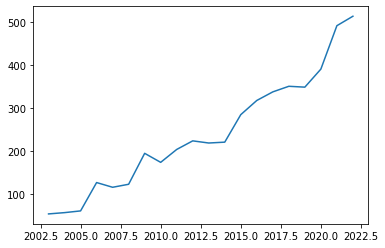

In [30]:
# Set the x-axis values
x = geriatric_trials['Year']

# Set the y-axis values for the first data set
y1 = geriatric_trials['Number of Trials']

# Set the y-axis values for the second data set

# Create the figure and the subplots
plt.plot(x,y1)
plt.show()

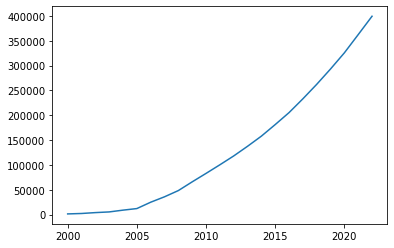

In [35]:
x = all_trials['Year First Posted']

# Set the y-axis values for the first data set
y1 = all_trials['Start of Year']

# Set the y-axis values for the second data set

# Create the figure and the subplots
plt.plot(x,y1)
plt.show()

In [ ]:
#Run time series regression analysis